[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1NZBq4g0oxL_RvmdzfBINscouUXmAbWnb?usp=sharing)

## Transfer Learning using TensorFlow Hub

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import matplotlib.pylab as plt
import datetime

In [ ]:
data_dir = tf.keras.utils.get_file(
    'flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True)

In [ ]:
data_dir

'/root/.keras/datasets/flower_photos'

In [ ]:
!ls -lrt /root/.keras/datasets/flower_photos

total 616
-rw-r----- 1 270850 5000 418049 Feb  9  2016 LICENSE.txt
drwx------ 2 270850 5000  40960 Feb 10  2016 tulips
drwx------ 2 270850 5000  36864 Feb 10  2016 sunflowers
drwx------ 2 270850 5000  36864 Feb 10  2016 roses
drwx------ 2 270850 5000  49152 Feb 10  2016 dandelion
drwx------ 2 270850 5000  36864 Feb 10  2016 daisy


In [ ]:
img_height = 224
img_width = 224
BATCH_SIZE = 128 

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  str(data_dir),
  validation_split=0.2,
  subset="training",
  seed=1,
  image_size=(img_height, img_width),
  batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
  str(data_dir),
  validation_split=0.2,
  subset="validation",
  seed=1,
  image_size=(img_height, img_width),
  batch_size=BATCH_SIZE
)

class_names = np.array(train_ds.class_names)
print(class_names)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.
['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)) 
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)) 

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(128, 224, 224, 3)
(128,)


## Using TensorFlow Hub

In [ ]:
inception_v3 = "https://tfhub.dev/google/imagenet/inception_v3/classification/5"

classifier_model = inception_v3

IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_model, input_shape=IMAGE_SHAPE+(3,))
])

labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

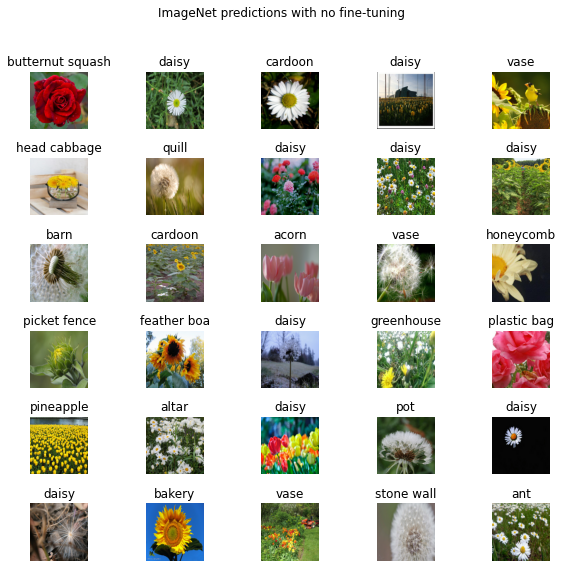

In [ ]:
result_batch = classifier.predict(train_ds)
predicted_class_names = imagenet_labels[tf.math.argmax(result_batch, axis=-1)]

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions with no fine-tuning")

In [ ]:
feature_extractor_model = inception_v3

feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(224, 224, 3),
    trainable=False)

In [ ]:
NUM_CLASSES = len(class_names)

model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(NUM_CLASSES)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1001)              23853833  
                                                                 
 dense (Dense)               (None, 5)                 5010      
                                                                 
Total params: 23,858,843
Trainable params: 5,010
Non-trainable params: 23,853,833
_________________________________________________________________


In [ ]:
pred = model(image_batch) 

In [ ]:
pred.shape

TensorShape([128, 5])

## Train model

In [ ]:
NUM_EPOCHS = 10

model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=NUM_EPOCHS).history

Epoch 1/10
23/23 [==============================] - 28s 992ms/step - loss: 1.3658 - acc: 0.5654 - val_loss: 0.8299 - val_acc: 0.7289
Epoch 2/10
23/23 [==============================] - 17s 722ms/step - loss: 0.6250 - acc: 0.7841 - val_loss: 0.6464 - val_acc: 0.7834
Epoch 3/10
23/23 [==============================] - 16s 721ms/step - loss: 0.4809 - acc: 0.8321 - val_loss: 0.5842 - val_acc: 0.8079
Epoch 4/10
23/23 [==============================] - 16s 719ms/step - loss: 0.4077 - acc: 0.8576 - val_loss: 0.5549 - val_acc: 0.8188
Epoch 5/10
23/23 [==============================] - 16s 718ms/step - loss: 0.3605 - acc: 0.8770 - val_loss: 0.5351 - val_acc: 0.8229
Epoch 6/10
23/23 [==============================] - 16s 718ms/step - loss: 0.3255 - acc: 0.8907 - val_loss: 0.5199 - val_acc: 0.8324
Epoch 7/10
23/23 [==============================] - 16s 718ms/step - loss: 0.2983 - acc: 0.9002 - val_loss: 0.5084 - val_acc: 0.8324
Epoch 8/10
23/23 [==============================] - 16s 718ms/step - 

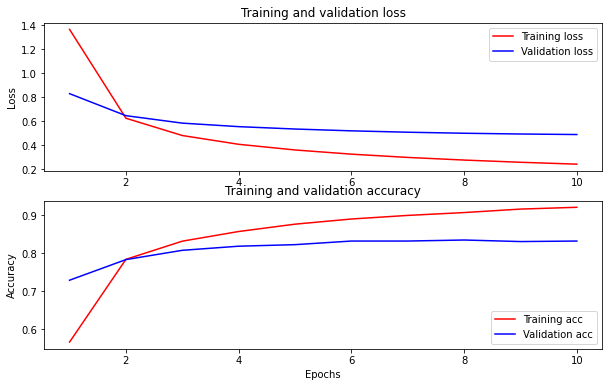

In [ ]:
acc = history['acc']
val_acc = history['val_acc']
loss = history['loss']
val_loss = history['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

## Check predictions

In [ ]:
image_batch, labels = next(iter(val_ds))

predicted_batch = model.predict(image_batch)
predicted_batch

array([[-4.31835890e+00, -4.49656439e+00,  8.28377604e-01,
        -2.05162477e+00,  6.79008389e+00],
       [-1.48967695e+00, -2.06118250e+00,  5.45953989e+00,
         5.70979786e+00,  1.61090064e+00],
       [-9.30232525e-01,  3.17985010e+00, -4.32423353e+00,
        -1.95251989e+00, -9.73707616e-01],
       [ 7.36957169e+00,  4.45636213e-01, -4.69325876e+00,
         1.41217828e+00, -3.62906766e+00],
       [-5.93778372e+00,  8.41596305e-01, -9.85082705e-03,
         2.01002121e+00, -1.44950664e+00],
       [-2.74079967e+00, -4.00444698e+00, -1.39515805e+00,
        -6.13416970e-01,  3.76201463e+00],
       [ 2.14383721e+00, -3.68559062e-01, -7.08516657e-01,
         7.20579863e+00, -4.44985294e+00],
       [ 6.95989227e+00,  1.28013682e+00, -2.02490187e+00,
         2.59624028e+00, -3.44503969e-02],
       [-4.27675533e+00, -3.72936487e+00,  1.51202357e+00,
        -1.30267143e+00,  2.75224543e+00],
       [-9.60516036e-01,  1.21379733e+00, -3.19964504e+00,
         2.73753953e+00

In [ ]:
predicted_batch.shape

(128, 5)

In [ ]:
class_names

array(['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'],
      dtype='<U10')

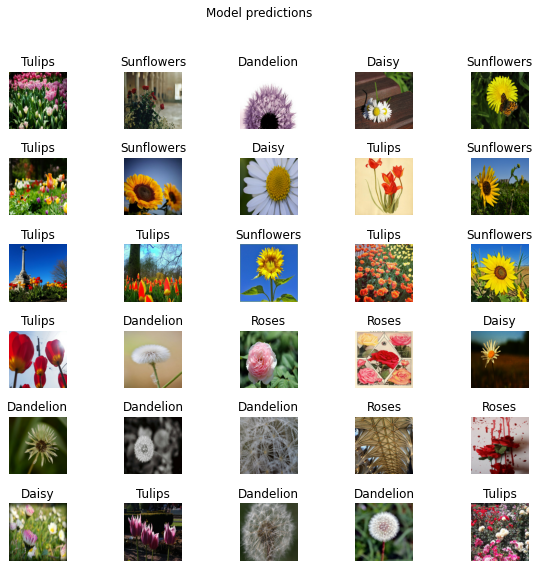

In [ ]:
predicted_id = tf.math.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)

for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions")